In [1]:
#imports
from torch.utils.data import Dataset
from math import floor, ceil
from torch import nn, optim
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
import pandas as pd 
import shutil
import os
import tarfile
from PIL import Image
import torch
import numpy as np

#define device
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [2]:
def organize_bird_images(csv_file, image_dir, output_dir):
    "Organizes images from the Waterbirds dataset into two classes: landbirds and waterbirds"
    # Create output directories for landbirds and waterbirds
    landbird_dir = os.path.join(output_dir, 'landbirds')
    waterbird_dir = os.path.join(output_dir, 'waterbirds')

    os.makedirs(landbird_dir, exist_ok=True)
    os.makedirs(waterbird_dir, exist_ok=True)

    # Read the CSV file which stores the image filenames with their image labels
    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():
        image_filename = row['img_filename']
        label = row['y'] 

        image_name = os.path.basename(image_filename)

        # Define the destination folder based on the label
        if label == 0:
            destination = os.path.join(landbird_dir, image_name)
        elif label == 1:
            destination = os.path.join(waterbird_dir, image_name)
        else:
            print(f"Invalid label for {image_name}. Skipping.")
            continue

        source_path = os.path.join(image_dir, image_filename)

        # Copy or move the image to the appropriate folder
        shutil.copy(source_path, destination)  # Use shutil.move() to move instead of copy

    print("Organized images into 'landbirds' and 'waterbirds' folders.")


# csv_file = ''  # Provide the path to your CSV file (metadata.csv)
# image_dir = ''  # Provide the path to your image directory (waterbird_complete95_forest2water2 folder)
# output_dir = ''  # Specify the output directory
# organize_bird_images(csv_file, image_dir, output_dir)


In [3]:
# The following implementation is based on the following paper and its corresponding code: 
# Levy, D., Carmon, Y., Duchi, J. C., & Sidford, A. (2020). 
# Large-scale methods for distributionally robust optimization. Advances in Neural Information Processing Systems, 33, 8847-8860.

def cvar_value(p, v, reg):
    "returns the CVaR value of a distribution given by p and v"
    m = v.shape[0]
    idx = torch.nonzero(p) # indices of non-zero elements of p
    kl = np.log(m) + (p[idx] * torch.log(p[idx])).sum() # KL divergence is calculated only for non-zero elements of p
        
    return torch.dot(p.squeeze(), v.squeeze()) - reg * kl

class Loss(torch.nn.Module):
    "returns the CVaR loss given by p and v"
    def __init__(self, alpha = 0.1, reg = 0.01, tol = 1e-4):
        super(Loss, self).__init__()
        self.alpha = alpha
        self.tol = tol
        self.reg = reg
        # set to cuda if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def response(self, v):
        "function that returns the response of v to the loss class given a certain alpha and reg"
        alpha = self.alpha
        reg = self.reg
        m = v.shape[0]

        # check if reg is larger than zero to avoid division by zero
        if reg>0:
            
            if alpha == 1.0:
                return torch.ones_like(v) / m
            
            def p(eta):
                "function that returns the probability distribution given eta"
                x = (v-eta)/reg
                new_x = torch.exp(x)
                alph = torch.Tensor([1.0/alpha]).type(x.dtype).to(self.device)
                m_tensor = torch.Tensor([m]).type(x.dtype).to(self.device)
                # returns the probability distribution as a tensor
                return torch.div(torch.min(new_x, alph), m_tensor)
            
            def bisection_target(eta):
                "function that returns the value of the bisection target as defined in the paper"
                return 1.0 - p(eta).sum()
            
            # finding eta using bisection method
            eta_min = reg * torch.logsumexp(v / reg - np.log(m), 0)
            eta_min = eta_min.squeeze()

            # if loop to check if the bisection target is smaller than the pre-defined tolerance
            if abs(bisection_target(eta_min))<=self.tol:
                return p(eta_min)
            else:
                # fail safe to avoid a None type distribution error
                cutoff = int(alpha * m)
                surplus = 1.0 - cutoff / (alpha * m)

                p = torch.zeros_like(v)
                idx = torch.argsort(v, descending=True)
                p[idx[:cutoff]] = 1.0 / (alpha * m)
                if cutoff < m:
                    p[idx[cutoff]] = surplus
                return p

        else:
            print('reg is 0')
        
    def forward(self, v):
        "returns the CVaR loss given by p and v"
        p = self.response(v)    
        return cvar_value(p, v, self.reg)

In [4]:
%matplotlib inline
def visualisation(train_losses, test_losses, average_accuracies, group_accuracies):
    "Visualise the training losses, test losses, average accuracies and group accuracies over the epochs of training"
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Subplot 1 - Plotting training losses
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses)
    axs[0, 0].set_title('Training Loss Per Epoch')
    axs[0, 0].set_xlabel('Number of Epochs')
    axs[0, 0].set_ylabel('Training Loss')

    # Subplot 2 - Plotting test losses
    axs[0, 1].plot(range(1, len(test_losses) + 1), test_losses)
    axs[0, 1].set_title('Test Loss Per Epoch')
    axs[0, 1].set_xlabel('Number of Epochs')
    axs[0, 1].set_ylabel('Test Loss')

    # Subplot 3 - Plotting average accuracies
    axs[1, 0].plot(range(1, len(average_accuracies) + 1), average_accuracies)
    axs[1, 0].set_title('Average Accuracy of Test Set Per Epoch')
    axs[1, 0].set_xlabel('Number of Epochs')
    axs[1, 0].set_ylabel('Average Test Accuracy (%)')

    # Subplot 4 - Plotting values in dictionaries for group accuracies
    for key in group_accuracies[0].keys():
        axs[1, 1].plot(range(1, len(group_accuracies) + 1), [d[key] for d in group_accuracies], label=key+1)

    axs[1, 1].set_title('Test Accuracy Per Group Per Epoch')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Number of Epochs')
    axs[1, 1].set_ylabel('Accuracy (%)')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [5]:
# The following code is based upon the paper and corresponding code:
# Liu, E. Z., Haghgoo, B., Chen, A. S., Raghunathan, A., Koh, P. W., Sagawa, S., ... & Finn, C. (2021, July). 
# Just train twice: Improving group robustness without training group information. In International Conference on Machine Learning (pp. 6781-6792). PMLR.

class CustomDataset(Dataset):
    "create a custom dataset which stores the path to the image in addition to the image itself and the label"
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_folders = os.listdir(data_dir)
        for class_folder in class_folders:
            class_path = os.path.join(data_dir, class_folder)
            if os.path.isdir(class_path):
                class_name = class_folder
                #we know the label of an image based on what folder it is in
                if class_name == "landbirds":
                    class_label = 0
                elif class_name == "waterbirds":
                    class_label = 1
                else:
                    continue

                for image_filename in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_filename)
                    self.image_paths.append(image_path)
                    self.labels.append(class_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        #apply transforms
        if self.transform:
            image = self.transform(image)

        filename = os.path.basename(image_path)
        label = self.labels[idx]

        return image, filename, label
    
def preprocess(directory, batch_size, select_percentage = 100):
    """Transform the images in the dataset and split into training and test sets. Has the option to select less than
            100% of the dataset during debugging phase."""
    transform = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])
    
    #create custom dataset with transforms
    data = CustomDataset(data_dir=directory, transform=transform)

    if select_percentage != 100:
        data = select_fraction(data, select_percentage)

    # Split the dataset into training and validation sets based on 80/20 split
    train_size = int(0.8 * len(data))
    val_size = len(data) - train_size
    train_dataset, val_dataset = random_split(data, [train_size, val_size])

    #we return two DataLoader objects, one for the training data and one for the test data
    return (DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True),
        DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False),
        )

def train_resnet50(train_loader, test_loader, model_path, epochs, learning_rate, cvar=False):
    """Train a ResNet50 architecture with default weights for the classification task of Waterbirds. The goal is to classify
    an image as either waterbird or landbird. Has the option to vary the number of epochs, learning rate and the use
    of CVaR Loss."""
    num_classes = 2
    
    #define Resnet50 architecture
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Freeze the layers except the last 4 layers
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes),
                                    nn.LogSoftmax(dim=1))
    
    #Depending on whether we will use CVaR loss we define the criterion for the training set
    if cvar==True:
        criterion = nn.CrossEntropyLoss(reduction='none')
        cvar_loss = Loss(alpha=0.001, reg=0.01, tol=1e-4, maxiter=50)
    else:
        criterion = nn.CrossEntropyLoss()
    
    #Define loss criterion for the test set
    criterion_test = nn.CrossEntropyLoss()
    
    #Use stochastic gradient descent
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum = 0.9)
    model.to(device)

    #initialise necessary variables to keep track of training progress
    steps = 0
    running_loss = 0
    #option to print losses and accuracies more or less often
    print_every = ceil(len(train_loader))
    train_losses, test_losses, average_accuracies, group_accuracies = [], [], [], []
    print("We're training with ", len(train_loader), " batches and ", len(train_loader) * 32, " images.")
    #start training
    for epoch in range(epochs):
        for inputs, filenames, labels in train_loader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            if cvar == True:
                loss = cvar_loss(loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, filenames, labels in test_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion_test(logps, labels)
                        test_loss += batch_loss.item()
                        
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                accuracies_per_group_dict = compute_accuracy_per_group(model, test_loader, filename_to_group_dict)
                group_accuracies.append(accuracies_per_group_dict)
                train_losses.append(running_loss/len(train_loader))
                test_losses.append(test_loss/len(test_loader))
                average_accuracies.append(accuracy/len(test_loader))
                print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(test_loader):.3f}.. "
                    f"Test average accuracy: {accuracy/len(test_loader):.3f}.."
                    f"Test group accuracies: {accuracies_per_group_dict}")
                running_loss = 0
                model.train()
    
    #save model for analysis
    torch.save(model, model_path)
    
    return train_losses, test_losses, average_accuracies, group_accuracies
    
def select_fraction(data, select_percentage):
    "Select a percentage of the dataset for faster running time during debugging."
    print("The initial size of the data is ", len(data))
    indices = list(range(len(data)))
    random.shuffle(indices)
    subset_indices = indices[:int(len(data) * (select_percentage / 100.0))]
    return torch.utils.data.Subset(data, subset_indices)

def get_misclassified_weights(model, train_loader, lambda_up):
    """Determine which images in the training set are misclassified by the model, and upsample these images with a 
    factor of lambda_up in the training set."""
    weights = []
    with torch.no_grad():
        for images, filenames, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_labels = torch.argmax(outputs, dim=1)
            #misclassified_mask will be true if the image is classified correctly and false if not
            misclassified_mask = predicted_labels != labels
            for classification in misclassified_mask:
                if classification:
                    weights.append(lambda_up)
                else:
                    weights.append(1)   
    return weights

def filename_to_group_dict(csv_file_path):
    """Determines the group of every image in the data using the metadata.csv file. The data can be in one of four groups: 
    landbird with land background, landbird with water background, waterbird with land background or waterbird with water
    background. Store each filename with its corresponding group in a dictionary."""
    # Read the CSV file into a DataFrame
    data = pd.read_csv(csv_file_path)

    # Initialize an empty dictionary
    filename_to_group = {}

    # Iterate through the DataFrame and map conditions to values
    for index, row in data.iterrows():
        filename = row['img_filename']
        last_slash_index = filename.rfind('/')
        if last_slash_index != -1:
            filename = filename[last_slash_index + 1:]
        y = row['y']
        place = row['place']

        if y == 0 and place == 0:
            filename_to_group[filename] = 0 #0 is landbird with land background
        elif y == 0 and place == 1:
            filename_to_group[filename] = 1 #1 is landbird with water background
        elif y == 1 and place == 0:
            filename_to_group[filename] = 2 #2 is waterbird with land background
        elif y == 1 and place == 1:
            filename_to_group[filename] = 3 #3 is waterbird with water background

    return filename_to_group

def compute_accuracy_per_group(model, test_loader, filename_to_group_dict):
    """Here we will compute the accuracies of the test set, separately for each of the four groups."""
    group_correct = {0:0,1:0,2:0,3:0}
    group_total = {0:0,1:0,2:0,3:0}
    #we will store the accuracies in a dictionary where the keys represent the groups and the values the accuracies of each group
    group_accuracies = {}
    
    for batch in test_loader:
        images, filenames, labels = batch
        images, labels = images.to(device), labels.to(device)

        for image, filename, label in zip(images, filenames, labels):
            image = image.unsqueeze(0)
            output = model(image)
            group = filename_to_group_dict.get(filename)
            #check if image was classified correctly
            if torch.argmax(output) == label.item():
                group_correct[group] += 1
            group_total[group] += 1
            
    group_accuracies[0] = group_correct[0]/group_total[0]
    group_accuracies[1] = group_correct[1]/group_total[1]
    group_accuracies[2] = group_correct[2]/group_total[2]
    group_accuracies[3] = group_correct[3]/group_total[3]
    
    return group_accuracies


We're training with  295  batches and  9440  images.
Epoch 1/30.. Train loss: 0.456.. Test loss: 0.341.. Test average accuracy: 0.866..Test group accuracies: {0: 1.0, 1: 0.9790209790209791, 2: 0.17058823529411765, 3: 0.5601092896174863}
Epoch 2/30.. Train loss: 0.295.. Test loss: 0.241.. Test average accuracy: 0.920..Test group accuracies: {0: 0.9984, 1: 0.9545454545454546, 2: 0.48823529411764705, 3: 0.8060109289617486}
Epoch 3/30.. Train loss: 0.240.. Test loss: 0.205.. Test average accuracy: 0.928..Test group accuracies: {0: 0.9944, 1: 0.9440559440559441, 2: 0.5882352941176471, 3: 0.8360655737704918}
Epoch 4/30.. Train loss: 0.224.. Test loss: 0.196.. Test average accuracy: 0.932..Test group accuracies: {0: 0.9928, 1: 0.9423076923076923, 2: 0.6294117647058823, 3: 0.8469945355191257}
Epoch 5/30.. Train loss: 0.212.. Test loss: 0.191.. Test average accuracy: 0.934..Test group accuracies: {0: 0.9896, 1: 0.9353146853146853, 2: 0.6764705882352942, 3: 0.8633879781420765}
Epoch 6/30.. Train

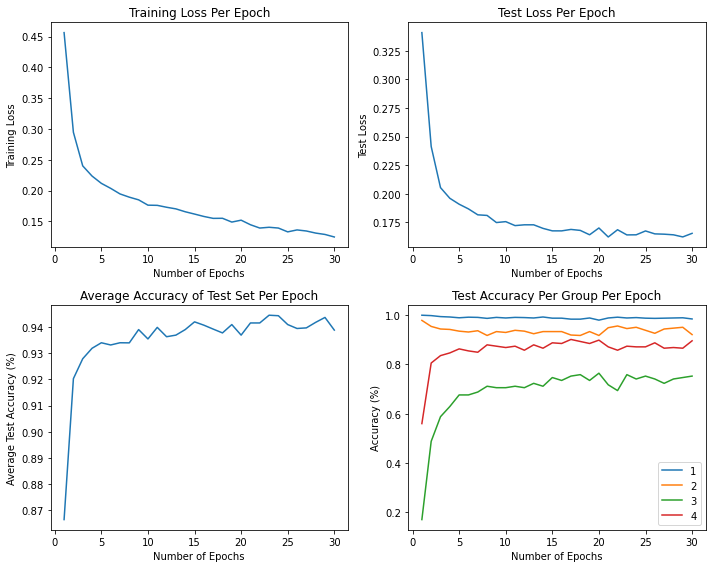

Now, length of train_loader is  539
We're training with  539  batches and  17248  images.
Epoch 1/100.. Train loss: 0.580.. Test loss: 0.519.. Test average accuracy: 0.772..Test group accuracies: {0: 1.0, 1: 1.0, 2: 0.0, 3: 0.0}
Epoch 2/100.. Train loss: 0.495.. Test loss: 0.464.. Test average accuracy: 0.772..Test group accuracies: {0: 1.0, 1: 1.0, 2: 0.0, 3: 0.0}
Epoch 3/100.. Train loss: 0.452.. Test loss: 0.420.. Test average accuracy: 0.782..Test group accuracies: {0: 1.0, 1: 1.0, 2: 0.011764705882352941, 3: 0.060109289617486336}
Epoch 4/100.. Train loss: 0.407.. Test loss: 0.376.. Test average accuracy: 0.841..Test group accuracies: {0: 1.0, 1: 0.9947552447552448, 2: 0.08823529411764706, 3: 0.4098360655737705}


In [ ]:
#execution

#define path to data and create filename to group dictionary to use later
path_to_data = 'data/waterbird_complete95_2class'
filename_to_group_dict = filename_to_group_dict('metadata.csv')

#preprocess the data
train_loader, test_loader = preprocess(path_to_data ,batch_size = 32, select_percentage=100)

#training round one and visualisation of the results
train_losses, test_losses, average_accuracies, group_accuracies = train_resnet50(train_loader, test_loader, 'JTT_one', epochs = 30, learning_rate = 0.001)
visualisation(train_losses, test_losses, average_accuracies, group_accuracies)

#load the model and upsample the misclassified training images in the training dataset
model = torch.load('JTT_one')
weights = get_misclassified_weights(model, train_loader, 20)
sampler = WeightedRandomSampler(weights, ceil(sum(weights)), replacement=True)
train_loader_new = DataLoader(
            train_loader.dataset, 
            batch_size=32, 
            sampler=sampler,
            shuffle=False)
print("Now, length of train_loader is ", len(train_loader_new))

#training round two with new training dataset and visualisation of the results
train_losses2, test_losses2, average_accuracies2, group_accuracies2 = train_resnet50(train_loader_new, test_loader, 'JTT_two', epochs = 100, learning_rate = 0.0001)
visualisation(train_losses2, test_losses2, average_accuracies2, group_accuracies2)
